In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import itertools as it
import subprocess as sp
import sys
import re
import collections
import json
import pysam
import enum
import bisect
import pgenlib as pg
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt

import colorlog

In [2]:
%matplotlib inline

In [3]:
sys.path.append('../../../src/')

In [4]:
import misc
from read import read
from bim_file import bim_file
from haplotype import Haplotype
from population_reference import population_reference
from find_haplotypes_from_vcf import find_haplotypes_from_vcf

/home/ytanigaw/.conda/envs/pgenlib/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
logger = colorlog.getLogger()
logger.setLevel(colorlog.colorlog.logging.DEBUG)
handler = colorlog.StreamHandler()
handler.setFormatter(colorlog.ColoredFormatter())
logger.addHandler(handler)

In [6]:
logger.debug("Debug message")
logger.info("Information message")
logger.warning("Warning message")
logger.error("Error message")
logger.critical("Critical message")

DEBUG:root:Debug message
INFO:root:Information message
ERROR:root:Error message
CRITICAL:root:Critical message


## options are given as a json object

In [7]:
params = {
    'validataion_vcf':
      '/share/PI/mrivas/data/PlatinumGenomes/2016-1.0/hg19/small_variants/NA12878/NA12878.vcf.gz',
    'bam_file_name':
      '/share/PI/mrivas/data/nanopore-wgs-consortium/poretools_fastq.12894489.geq12500.bam',
    'fasta_ext':
      'fa',
    'ref_genome_template':
      '/share/PI/mrivas/data/hg19/chr${CHR}.${EXT}',
    'ref_population_template':
      '/share/PI/mrivas/data/1000genomes/ALL.chr${CHR}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.${EXT}'
}

In [8]:
json.dumps(params)

'{"bam_file_name": "/share/PI/mrivas/data/nanopore-wgs-consortium/poretools_fastq.12894489.geq12500.bam", "ref_genome_template": "/share/PI/mrivas/data/hg19/chr${CHR}.${EXT}", "validataion_vcf": "/share/PI/mrivas/data/PlatinumGenomes/2016-1.0/hg19/small_variants/NA12878/NA12878.vcf.gz", "ref_population_template": "/share/PI/mrivas/data/1000genomes/ALL.chr${CHR}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.${EXT}", "fasta_ext": "fa"}'

In [9]:
chromosome = 20

## need to look up file name for reference data
- misc.py

In [10]:
print misc.get_fasta_file_name(params, 20)
print misc.get_pgen_file_name(params, 20)
print misc.get_bim_file_name(params, 20)

/share/PI/mrivas/data/hg19/chr20.fa
/share/PI/mrivas/data/1000genomes/ALL.chr20.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.pgen
/share/PI/mrivas/data/1000genomes/ALL.chr20.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.bim


## Data structures for Nucleotide and Mismatch (on reads)

- misc.py

## reference genome

In [11]:
reference = pysam.FastaFile(misc.get_fasta_file_name(params, 20))

## bim file

- bim_file.py

In [12]:
bim = bim_file(params)
print bim.get_id(20)
print bim.get_bp(20)

['rs527639301' 'rs538242240' 'rs149529999' ..., 'rs563604166' 'rs577023641'
 'rs546194182']
[   60342    60418    60478 ..., 62965289 62965304 62965353]


In [13]:
print bim.find_index_interval(20, 60342, 60419)
print bim.find_index_interval(20, 60343, 60420)
print bim.find_index_interval(20, 60344, 60421)
print [x for x in range(1, 2)]

(0, 2)
(1, 2)
(1, 2)
[1]


## read bam file

- read.py

In [14]:
bamfile = pysam.AlignmentFile(filename = params['bam_file_name'], 
                              mode = 'rb')


In [15]:
#aligned_segment = bamfile.next()
aligned_segments = [bamfile.next() for i in range(10)]

In [16]:
r = read(aligned_segments[0], reference)

In [17]:
print(r)

chr20:59980-65177	5190	7	60	33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template


In [18]:
r.get_mismatches()

[Mismatch(reference_position=60992, reference=<Nucleotide.G: 2>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61171, reference=<Nucleotide.A: 0>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61220, reference=<Nucleotide.G: 2>, read=<Nucleotide.A: 0>, quality=17),
 Mismatch(reference_position=63344, reference=<Nucleotide.T: 3>, read=<Nucleotide.A: 0>, quality=15),
 Mismatch(reference_position=63377, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63378, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63798, reference=<Nucleotide.C: 1>, read=<Nucleotide.T: 3>, quality=15)]

In [19]:
r.get_mismatches_pos()

array([60992, 61171, 61220, 63344, 63377, 63378, 63798])

In [20]:
r.get_mismatches_polymorphic(bim)

array([], dtype=float64)

In [21]:
r.get_mismatches_polymorphic_pos(bim)

array([], dtype=float64)

#### read specific error rate

In [22]:
r.non_polymorphic_error_rate(bim=bim)

0.0011850681414181316

## pgen file for population reference
- haplotype.py
- population_reference.py

In [23]:
pgen = population_reference(params)

In [92]:
class Haplotype_block:
    def __init__(self, chromosome, idx_l, idx_r, bim, pgen):
        self.chromosome = chromosome
        self.idx_l = idx_l
        self.idx_r = idx_r        
        self.bim = bim
        self.bim_idx_l, self.bim_idx_r = \
        bim.find_index_interval(chromosome, idx_l, idx_r)
        
        # read_pgen_file
        alleles = pgen.read_alleles(chromosome, self.bim_idx_l, self.bim_idx_r)
        
        self.alleles = alleles # we don't need it. keeping for debug purpose
        
        self.pop_size = alleles.shape[1]
        
        cnt = collections.Counter([tuple(alleles[:, i]) 
                                   for i in range(self.pop_size)])
        
        # number of unique haplotypes
        self.n_uniq_haps = len(cnt.keys())
        
        # find unique haplotypes and their occurance in population
        cnt_sorted = cnt.most_common(self.n_uniq_haps)
        self.haps = np.array([cnt_sorted[i][0] for i
                              in range(self.n_uniq_haps)], dtype = np.int8)
        self.cnts = np.array([cnt_sorted[i][1] for i 
                              in range(self.n_uniq_haps)], dtype = np.int)
        
        # log p(data | haplotype) = \sum_{read \in data} p(read | haplotype)
        self.log_likelihood = np.zeros(self.n_uniq_haps, dtype = np.float)
        self.n_pos_total = 0

    def log_prior(self):
        return(np.log(self.cnts) - np.log(self.pop_size))
    
    def log_posterior(self):
        log_potential = np.log(self.cnts) + self.log_likelihood
        log_part = np.log(np.sum(np.exp(log_potential)))
        return(log_potential - log_part)

    def update_model_read_specific(self, read, bim):
        # take intersection of read and the haplotype block
        bim_min = max(self.bim_idx_l, read.get_bim_interval(bim)[0])
        bim_max = min(self.bim_idx_r, read.get_bim_interval(bim)[1])
        
        # number of positions we consider in this update
        n_pos = max(0, bim_max - bim_min)
        
        # mismatch between reference and read
        mm_ref_vs_read = \
        read.get_mismatches_polymorphic_pos(bim, 
                                            bim.get_bp(self.chromosome)[bim_min], 
                                            bim.get_bp(self.chromosome)[bim_max])
        # polymorphic positions
        poly_pos = bim.get_bp(self.chromosome)[bim_min:bim_max]
        
        # For each haplotype, find set of 
        mm_ref_vs_haps = [poly_pos[hb.haps[i][bim_min - self.bim_idx_l :
                                              bim_max - self.bim_idx_l] == 1]
                          for i in range(self.n_uniq_haps)]
        
        # number of mismatches between read and haplotype
        #   need to fix later
        x = np.array([len(set(mm_ref_vs_read) ^ set(mm_ref_vs_haps[i]))
                      for i in range(self.n_uniq_haps)])
                
        e = read.non_polymorphic_error_rate(bim)
        
        self.log_likelihood = self.log_likelihood + np.log(e) * x + np.log(1 - e) * (n_pos - x)
        self.n_pos_total = self.n_pos_total + n_pos
    
    def map_value(self):
        return(np.exp(max(self.log_posterior())))
    
    def map_index(self):
        return(np.where(self.log_posterior() >= max(self.log_posterior()))[0])
    
    def plot(self, filename = None):
        if(filename is not None):
            logger.info('Writing image to {}'.format(filename))
        misc.make_hist(x = np.exp(self.log_posterior()),
                  title = ' '.join(['Haplotype probability distribution',
                                    'after {:.2} observations'.format(1.0 * self.n_pos_total / 
                                                                      (self.bim_idx_r - self.bim_idx_l)),
                                    '\n({} unique haplotypes in'.format(self.n_uniq_haps),
                                    'chr{}:{}-{} ({}SNPs))'.format(self.chromosome,
                                                                   self.idx_l,
                                                                   self.idx_r, 
                                                                   self.bim_idx_r - self.bim_idx_l
                                                                  )]),
                  xlabel = ' '.join(['Haplotype probability',
                                     '(population size: {} haplotypes)'.format(self.pop_size)]),
                  ylabel = 'Frequency of haplotype probabilities', 
                  filename = None)    
    

In [93]:
print(r)

chr20:59980-65177	5190	7	60	33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template


In [94]:
hb = Haplotype_block(20, 60000, 65000, bim, pgen)

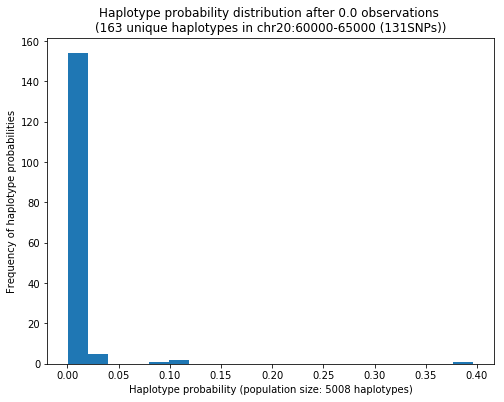

In [95]:
hb.plot()

In [96]:
hb.update_model_read_specific(r, bim)

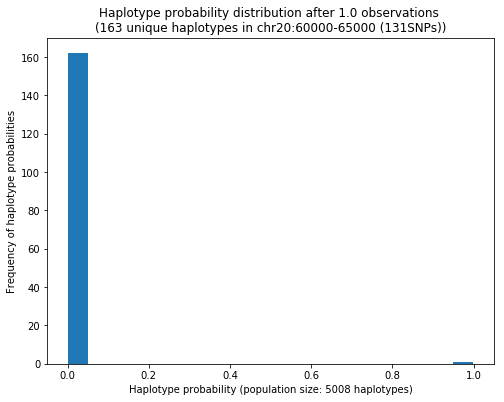

In [97]:
hb.plot()

In [98]:
hb.map_value()

0.99960681871802282

In [101]:
hb.map_index()

array([0])

In [102]:
hb.haps[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [103]:
r.non_polymorphic_error_rate(bim)

0.0011850681414181316

In [75]:
e

0.0011850681414181316

In [81]:
np.log(e) * x + np.log(1 - e) * (n_pos - x)

array([ -0.15533599, -33.83918215,  -6.89210522, -27.10241291,
       -13.62887445, -27.10241291, -40.57595138, -20.36564368,
       -20.36564368, -13.62887445,  -6.89210522, -27.10241291,
       -33.83918215, -13.62887445, -27.10241291,  -6.89210522,
       -20.36564368, -20.36564368, -27.10241291, -40.57595138,
       -40.57595138, -20.36564368,  -6.89210522, -47.31272061,
       -20.36564368, -27.10241291, -20.36564368, -27.10241291,
       -33.83918215, -27.10241291, -20.36564368, -33.83918215,
       -33.83918215, -20.36564368, -27.10241291,  -6.89210522,
       -40.57595138,  -6.89210522, -13.62887445, -13.62887445,
       -54.04948984, -40.57595138, -33.83918215, -33.83918215,
       -33.83918215,  -6.89210522, -40.57595138,  -6.89210522,
        -6.89210522, -33.83918215, -33.83918215, -27.10241291,
       -33.83918215,  -6.89210522, -47.31272061, -13.62887445,
       -33.83918215, -27.10241291, -20.36564368, -33.83918215,
        -6.89210522, -13.62887445, -33.83918215, -33.83

In [31]:
hb.alleles.shape

(131, 5008)

In [32]:
r.get_mismatches()

[Mismatch(reference_position=60992, reference=<Nucleotide.G: 2>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61171, reference=<Nucleotide.A: 0>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61220, reference=<Nucleotide.G: 2>, read=<Nucleotide.A: 0>, quality=17),
 Mismatch(reference_position=63344, reference=<Nucleotide.T: 3>, read=<Nucleotide.A: 0>, quality=15),
 Mismatch(reference_position=63377, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63378, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63798, reference=<Nucleotide.C: 1>, read=<Nucleotide.T: 3>, quality=15)]

In [33]:
print(hb.bim_idx_l, hb.bim_idx_r)
print(r.get_bim_interval(bim))

(0, 131)
(0, 134)


In [34]:
max(hb.bim_idx_l, r.get_bim_interval(bim)[0])

0

In [35]:
min(hb.bim_idx_r, r.get_bim_interval(bim)[1])

131

In [38]:
bim.get_bp(20)[0:131][hb.haps[1][0:131] == 1]

array([61097, 61137, 61794, 63243, 63798])

In [71]:
mismatch_to_ref = r.get_mismatches_polymorphic_pos(bim, bim.get_bp(20)[0], bim.get_bp(20)[131])
n_mismatch_to_ref = len(mismatch_to_ref)

In [73]:
print mismatch_to_ref
print n_mismatch_to_ref

[]
0


In [37]:
hb.haps[1][0:131] == 1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [78]:
r.get_mismatches(bim)

[Mismatch(reference_position=60025, reference=<Nucleotide.G: 2>, read=<Nucleotide.A: 0>, quality=3),
 Mismatch(reference_position=60054, reference=<Nucleotide.C: 1>, read=<Nucleotide.G: 2>, quality=4),
 Mismatch(reference_position=60055, reference=<Nucleotide.A: 0>, read=<Nucleotide.C: 1>, quality=5),
 Mismatch(reference_position=60059, reference=<Nucleotide.C: 1>, read=<Nucleotide.T: 3>, quality=6),
 Mismatch(reference_position=60060, reference=<Nucleotide.C: 1>, read=<Nucleotide.G: 2>, quality=4),
 Mismatch(reference_position=60076, reference=<Nucleotide.A: 0>, read=<Nucleotide.G: 2>, quality=4),
 Mismatch(reference_position=60082, reference=<Nucleotide.G: 2>, read=<Nucleotide.A: 0>, quality=7),
 Mismatch(reference_position=60086, reference=<Nucleotide.A: 0>, read=<Nucleotide.T: 3>, quality=6),
 Mismatch(reference_position=60087, reference=<Nucleotide.G: 2>, read=<Nucleotide.T: 3>, quality=4),
 Mismatch(reference_position=60104, reference=<Nucleotide.G: 2>, read=<Nucleotide.A: 0>, qu

In [ ]:
poly_sites = bim.get_bp(20)[0 : 131]

In [33]:
print(hb.bim_idx_l, hb.bim_idx_r)

(0, 131)


In [43]:
poly_sites = bim.get_bp(20)[hb.bim_idx_l : hb.bim_idx_r]

In [42]:
poly_sites[hb.haps[0] == 1]

array([], dtype=int64)

In [31]:
r.get_bim_interval(bim)

(0, 134)

In [50]:
r.get_mismatches_pos()

array([60992, 61171, 61220, 63344, 63377, 63378, 63798])

In [48]:
hb.haps[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [47]:
hb.haps[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [34]:
hb_wide = Haplotype_block(20, 60000, 90000, bim, pgen)

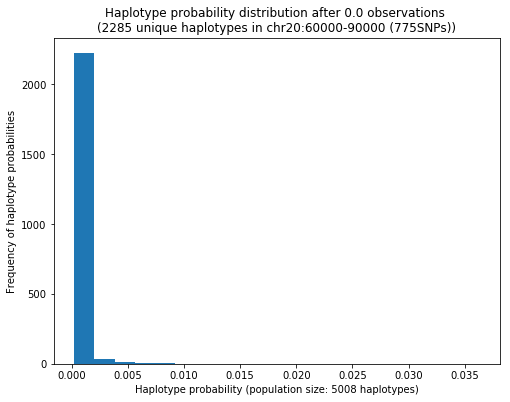

In [35]:
hb_wide.plot()

In [38]:
np.sum(hb_wide.cnts == 1)

1676

In [116]:
bim.get_bp(20)[:300]

array([60342, 60418, 60478, 60521, 60567, 60570, 60578, 60648, 60777,
       60794, 60807, 60809, 60825, 60827, 60863, 60894, 60915, 61043,
       61069, 61097, 61117, 61137, 61269, 61270, 61271, 61278, 61328,
       61387, 61408, 61436, 61449, 61516, 61537, 61637, 61650, 61710,
       61723, 61794, 61954, 61971, 62099, 62173, 62254, 62282, 62347,
       62386, 62419, 62460, 62470, 62477, 62544, 62552, 62555, 62587,
       62730, 62738, 62782, 62787, 62795, 62820, 62827, 62838, 62879,
       62945, 62954, 62974, 62999, 63007, 63053, 63154, 63230, 63243,
       63256, 63288, 63309, 63350, 63359, 63398, 63425, 63451, 63520,
       63540, 63547, 63552, 63554, 63558, 63585, 63635, 63695, 63697,
       63728, 63732, 63798, 63807, 63812, 63856, 63864, 63901, 63962,
       63966, 63976, 64015, 64061, 64149, 64150, 64153, 64174, 64185,
       64209, 64302, 64307, 64322, 64357, 64368, 64381, 64431, 64441,
       64452, 64508, 64525, 64538, 64583, 64602, 64624, 64664, 64671,
       64708, 64737,

In [71]:
hb.haps

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [72]:
hb.cnts

array([1985,  563,  510,  459,  192,  183,  176,  164,  104,   85,   70,
         50,   27,   26,   18,   16,   16,   15,   13,   13,   10,    9,
          9,    9,    9,    8,    8,    8,    7,    6,    6,    6,    6,
          5,    5,    5,    5,    5,    5,    4,    4,    4,    4,    4,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          3,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,   

In [73]:
# indices are 
bim.find_index_interval(r.reference_chr, r.reference_start, r.reference_end)

(0, 134)

In [75]:
r.get_mismatches_polymorphic(bim)

array([], dtype=float64)

In [76]:
r.get_mismatches()

[Mismatch(reference_position=60992, reference=<Nucleotide.G: 2>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61171, reference=<Nucleotide.A: 0>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61220, reference=<Nucleotide.G: 2>, read=<Nucleotide.A: 0>, quality=17),
 Mismatch(reference_position=63344, reference=<Nucleotide.T: 3>, read=<Nucleotide.A: 0>, quality=15),
 Mismatch(reference_position=63377, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63378, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63798, reference=<Nucleotide.C: 1>, read=<Nucleotide.T: 3>, quality=15)]

In [26]:
# the first read spans
r.reference_chr, r.reference_start, r.reference_end

(20, 59980, 65177)

In [28]:
bim.raw_tables['20'].head()

,chr,id,morgan,bp,allele_1,allele_2
0,20,rs527639301,0,60343,A,G
1,20,rs538242240,0,60419,G,A
2,20,rs149529999,0,60479,T,C
3,20,rs150241001,0,60522,TC,T
4,20,rs533509214,0,60568,C,A


In [29]:
for bp in bim.get_bp(20)[:5]:
    print reference.fetch(reference = 'chr20', start     = bp, end       = bp + 1)

g
a
c
t
a


In [30]:
# indices are 
bim.find_index_interval(r.reference_chr, r.reference_start, r.reference_end)

(0, 134)

In [31]:
# haplotypes are
haps = pgen.read_haplotype(r.reference_chr, 0, 134)

In [32]:
print haps[0]

Hap_20:0-134_00000000000000000000000000000000000001000000000000000010000000000000000000000000000000000000100000000000000000000000000000000000000000


In [33]:
print haps[1]

Hap_20:0-134_00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


In [34]:
haps[0].dist(haps[1])

3

In [44]:
haps

[<haplotype.Haplotype instance at 0xc41d758>,
 <haplotype.Haplotype instance at 0xc41c1b8>,
 <haplotype.Haplotype instance at 0xc41cdd0>,
 <haplotype.Haplotype instance at 0xc41cbd8>,
 <haplotype.Haplotype instance at 0xc41ccb0>,
 <haplotype.Haplotype instance at 0xc41cb48>,
 <haplotype.Haplotype instance at 0xc41c998>,
 <haplotype.Haplotype instance at 0xc41cc68>,
 <haplotype.Haplotype instance at 0xc41ca70>,
 <haplotype.Haplotype instance at 0xc41ca28>,
 <haplotype.Haplotype instance at 0xc41c878>,
 <haplotype.Haplotype instance at 0xc41cb00>,
 <haplotype.Haplotype instance at 0xc41c950>,
 <haplotype.Haplotype instance at 0xc41c908>,
 <haplotype.Haplotype instance at 0xc41c710>,
 <haplotype.Haplotype instance at 0xc41c9e0>,
 <haplotype.Haplotype instance at 0xc41c830>,
 <haplotype.Haplotype instance at 0xc41c7a0>,
 <haplotype.Haplotype instance at 0xc41c5f0>,
 <haplotype.Haplotype instance at 0xc41c8c0>,
 <haplotype.Haplotype instance at 0xc41c6c8>,
 <haplotype.Haplotype instance at 

## Haplotype block

In [35]:
class Haplotype_block:
    '''Class to represent Haplotype block and associated population reference
    '''
    def __init__(self, chromosome, index_l, index_r, haps):
        self.chromosome = chromosome
        self.index_l = index_l
        self.index_r = index_r
        self.haps = haps
        self.population_size = len(haps)
        
        # We will work on hash of the haplotypes, 
        # we need to have inverse of hash function 
        # to go back to the original haplotypes
        self.inv_hash = dict(zip([h.__hash__() for h in haps], self.haps))

        # count
        self.count = collections.Counter([h.__hash__() for h in haps])        
        self.hash_keys = self.count.keys()
        self.n_uniq_haps    = len(self.hash_keys)
        
        # inference
        self.log_prior      = self.find_log_prior()
        self.log_posterior  = self.log_prior
        self.n_observations = np.zeros(index_r - index_l, dtype = np.uint)
    
    def find_log_prior(self):
        count = np.array([self.count[hash_key] for hash_key in self.hash_keys], 
                         dtype = np.float)
        return(np.log(count) - np.log(self.population_size))
    
    def map_value(self):
        return(np.exp(max(self.log_posterior)))
    
    def map_index(self):
        return(np.where(self.log_posterior >= max(self.log_posterior))[0])
    
    def map_haplotype(self):
        return([self.inv_hash[self.hash_keys[key_index]]
                for key_index in self.map_index()])
    
    def plot(self, filename = None):
        if(filename is not None):
            logger.info('Writing image to {}'.format(filename))
        misc.make_hist(x = np.exp(self.log_posterior),
                  title = ' '.join(['Haplotype probability distribution',
                                    'after {:.2} observations'.format(np.average(self.n_observations)),
                                    '\n({} unique haplotypes in'.format(self.n_uniq_haps),
                                    'chr{}:{}-{} SNPs region)'.format(self.chromosome,
                                                                      self.index_l,
                                                                      self.index_r)]),
                  xlabel = ' '.join(['Haplotype probability',
                                     '(population size: {} haplotypes)'.format(self.population_size)]),
                  ylabel = 'Frequency of haplotype probabilities', 
                  filename = None)

In [41]:
hb.hash_keys[0]

165049069602753025

In [43]:
print hb.inv_hash[hb.hash_keys[0]]

Hap_20:0-134_00000100000000000000000000000000000001000000000000000000000000010000000000000000000000000000100000000000000000000000000000000000000000


In [36]:
hb = Haplotype_block(20, 0, 134, haps)

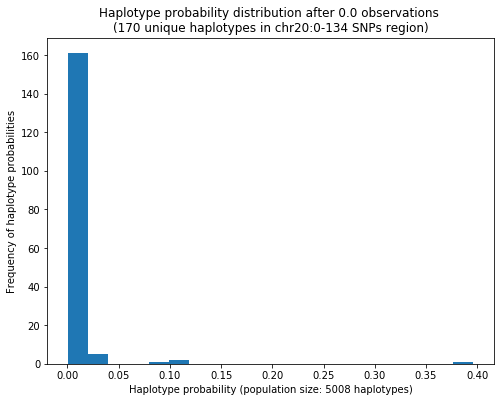

In [37]:
hb.plot()

In [38]:
print hb.map_haplotype()[0]
print hb.map_value()

Hap_20:0-134_00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0.396365814696


In [39]:
hb.count

Counter({-9175677958307953808: 2,
         -9130832840575974687: 26,
         -9044589197689186199: 1,
         -8889961977414400567: 192,
         -8889634510052458573: 2,
         -8737581320481467306: 1,
         -8684975066678322338: 2,
         -8626650307732181592: 2,
         -8535871547584943363: 2,
         -8414447340068092848: 2,
         -8344566858101327297: 1985,
         -8344565489477867772: 1,
         -8253999997713297563: 1,
         -8181701627128580684: 1,
         -8035074705709774561: 1,
         -8024963132335416380: 4,
         -7979329340941921891: 2,
         -7935562418909386284: 1,
         -7897876175291348119: 1,
         -7828428332729841210: 1,
         -7773479352472181122: 2,
         -7773474997810396047: 4,
         -7449152018324942636: 1,
         -7251663154803421018: 1,
         -7187506471138238727: 4,
         -7167074757364132588: 1,
         -7148621607149576276: 104,
         -7033820082469824677: 1,
         -7008461354668141220: 2,
      

## inference

In [34]:
print(r)

chr20:59980-65177	5190	7	60	33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template


In [35]:
r.non_polymorphic_error_rate(bim)

0.0013825794983211535

In [37]:
r.get_mismatches_polymorphic(bim)

array([], dtype=float64)

In [39]:
r.n_polymorphic_sites(bim)

134

## define correct label for NA12878 data
- find_haplotypes_from_vcf.py

In [35]:
tbx = pysam.TabixFile(params['validataion_vcf'])

In [36]:
na12878_haps = find_haplotypes_from_vcf(tbx, bim, 20, 59980, 65117)

In [37]:
na12878_haps

array([[-9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9,  1, -9,  1, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9,  1, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9,  1, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9,  1, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9],
       [-9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9,  0, -9,  0, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9,  0, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9,  0, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9,

# TODO
- manage haplotype block
  - partition bim file
- inference